# London Weather Trends: Exploratory Analysis  

In this notebook, we explore London’s weather data with a focus on temperature and precipitation.  
The goal is to clean the dataset, visualize seasonal and long-term changes, and uncover relationships between temperature and rainfall.  

---

# Load & Inspect Data
---

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

plt.style.use("seaborn-v0_8")

df = pd.read_csv("london_weather.csv")

print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              15341 non-null  int64  
 1   cloud_cover       15322 non-null  float64
 2   sunshine          15341 non-null  float64
 3   global_radiation  15322 non-null  float64
 4   max_temp          15335 non-null  float64
 5   mean_temp         15305 non-null  float64
 6   min_temp          15339 non-null  float64
 7   precipitation     15335 non-null  float64
 8   pressure          15337 non-null  float64
 9   snow_depth        13900 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 1.2 MB
None
               date   cloud_cover      sunshine  global_radiation  \
count  1.534100e+04  15322.000000  15341.000000      15322.000000   
mean   1.999567e+07      5.268242      4.350238        118.756951   
std    1.212176e+05      2.070072      4.028339         88.898272

# Data Cleaning
---

In [59]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
df = df.set_index('date')


### Handle missing values

In [60]:
print(df.isna().sum())

df['max_temp'] = df['max_temp'].interpolate()
df['mean_temp'] = df['mean_temp'].interpolate()
df['min_temp'] = df['min_temp'].interpolate()

df['cloud_cover'] = df['cloud_cover'].interpolate(method='time')

df['global_radiation'] = df['global_radiation'].interpolate(method='time')

df['pressure'] = df['pressure'].interpolate(method='time')

df['snow_depth'] = df['snow_depth'].fillna(0)


cloud_cover           19
sunshine               0
global_radiation      19
max_temp               6
mean_temp             36
min_temp               2
precipitation          6
pressure               4
snow_depth          1441
dtype: int64


### Remove duplicate data

In [61]:
df = df.drop_duplicates()

### Handle outliers

In [62]:
def remove_outliers_std(df, col, n_std=3):
    mean = df[col].mean()
    std = df[col].std()
    return df[(df[col] >= mean - n_std*std) & (df[col] <= mean + n_std*std)]

df = remove_outliers_std(df, 'mean_temp', n_std=3)

In [63]:
def remove_outliers_iqr(df, col, factor=1.5):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[col] >= Q1 - factor*IQR) & (df[col] <= Q3 + factor*IQR)]

df = remove_outliers_iqr(df, 'precipitation', factor=1.5)

#### Getting rid of impossible values

In [64]:
df = df[df['precipitation'] >= 0]
df = df[df['min_temp'] <= df['max_temp']]

### Data Cleaning Summary  

At this stage, the dataset has been cleaned:  
- Missing values were interpolated.  
- Duplicates were removed.  
- Extreme outliers in temperature and rainfall were treated.  
The data is now ready for feature engineering and visualization.  
---

# Feature Engineering
---

### Split date to Months and Year column to add seasons

In [65]:
df['mean_temp'] = df['mean_temp'].fillna(df['mean_temp'].rolling(7).mean())

df['month'] = df.index.month
df['year'] = df.index.year
df['season'] = df['month'].map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
})

print(df.tail())

            cloud_cover  sunshine  global_radiation  max_temp  mean_temp  \
date                                                                       
2020-12-25          6.0       3.5              40.0       4.6        2.6   
2020-12-28          7.0       3.7              38.0       3.6        1.1   
2020-12-29          7.0       0.0              21.0       4.1        2.6   
2020-12-30          6.0       0.4              22.0       5.6        2.7   
2020-12-31          7.0       1.3              34.0       1.5       -0.8   

            min_temp  precipitation  pressure  snow_depth  month  year  season  
date                                                                            
2020-12-25       0.7            0.0  103100.0         0.0     12  2020  Winter  
2020-12-28      -1.3            0.2   97370.0         0.0     12  2020  Winter  
2020-12-29       1.1            0.0   98830.0         0.0     12  2020  Winter  
2020-12-30      -0.1            0.0  100200.0         0.0     

### Feature Engineering  

We extracted **month**, **year**, and **season** from the date column.  
These new features allow us to analyze both seasonal patterns and long-term climate trends.  

---

# Exploratry Visualisation
---

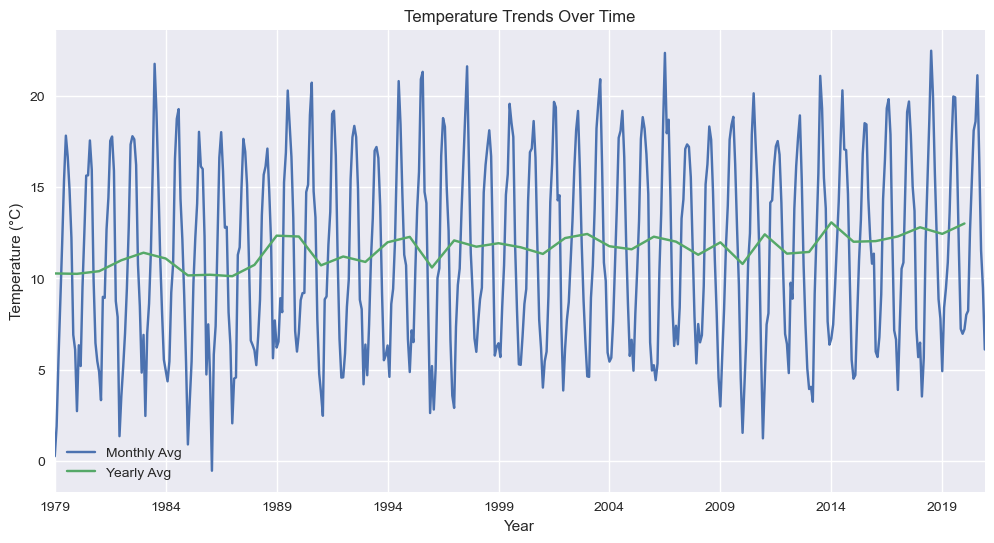

In [66]:
### Temperature Trends Over Time

plt.figure(figsize=(12, 6))
df['mean_temp'].resample('M').mean().plot(label='Monthly Avg')
df['mean_temp'].resample('Y').mean().plot(label='Yearly Avg')
plt.title("Temperature Trends Over Time")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()

#### Temperature Trends Over Time

This line plot shows London’s average monthly and yearly temperatures.  
Seasonal cycles are clear, with warmer summers and cooler winters repeating each year.  
The yearly averages smooth out short-term fluctuations, making long-term stability more visible.  


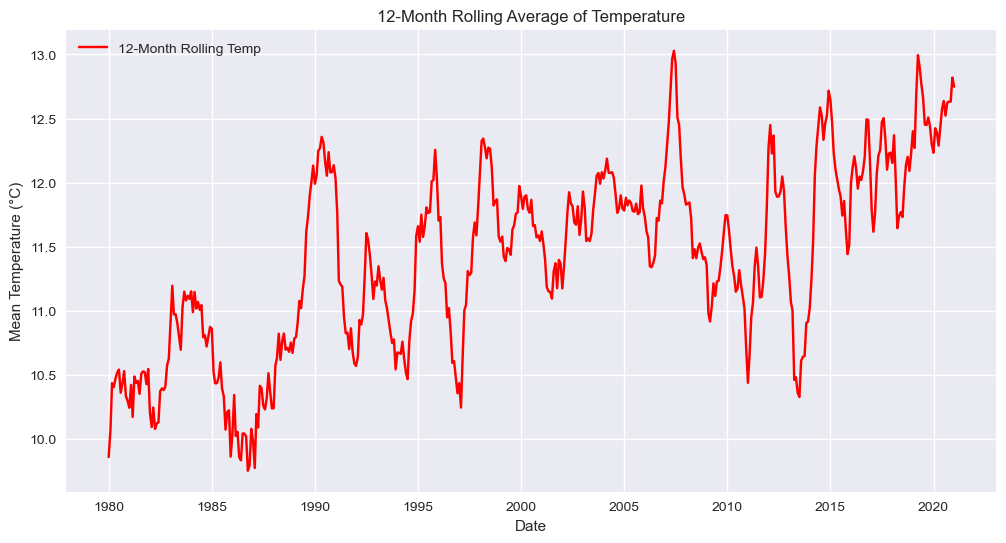

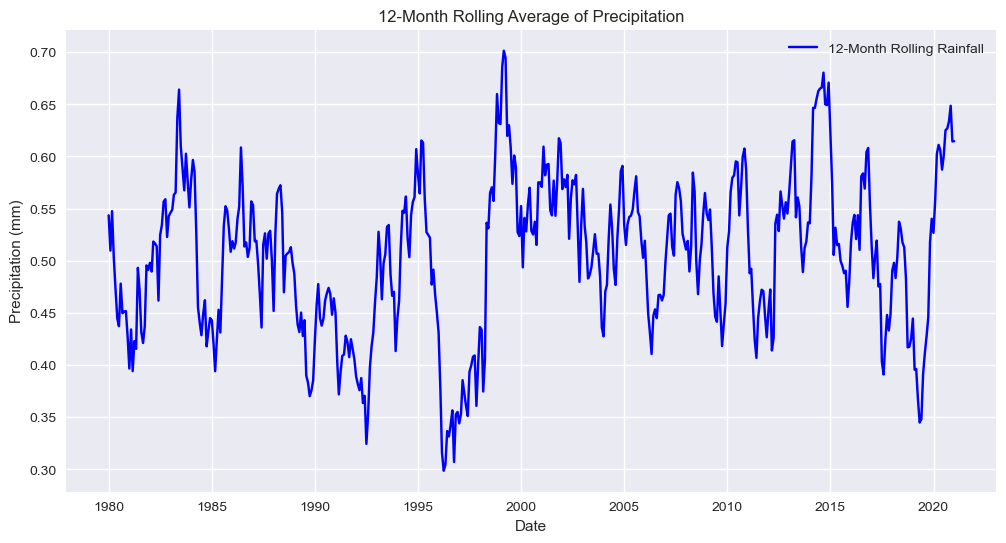

In [67]:
# 12-month rolling average for temperature & precipitation
rolling = df[['mean_temp','precipitation']].resample('M').mean().rolling(window=12).mean()

plt.figure(figsize=(12,6))
plt.plot(rolling.index, rolling['mean_temp'], label="12-Month Rolling Temp", color="red")
plt.title("12-Month Rolling Average of Temperature")
plt.xlabel("Date")
plt.ylabel("Mean Temperature (°C)")
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(rolling.index, rolling['precipitation'], label="12-Month Rolling Rainfall", color="blue")
plt.title("12-Month Rolling Average of Precipitation")
plt.xlabel("Date")
plt.ylabel("Precipitation (mm)")
plt.legend()
plt.show()


### Smoothed Long-Term Climate Trends
Short-term fluctuations can hide larger patterns. By applying a **12-month rolling average**, we see clearer climate signals:  
- For temperature, the rolling curve highlights **warming or cooling periods** across decades.  
- For rainfall, it helps detect **long-term shifts in precipitation** (e.g., wetter vs. drier decades).  
This is especially useful in climate studies, as it reveals **persistent changes** rather than noise.


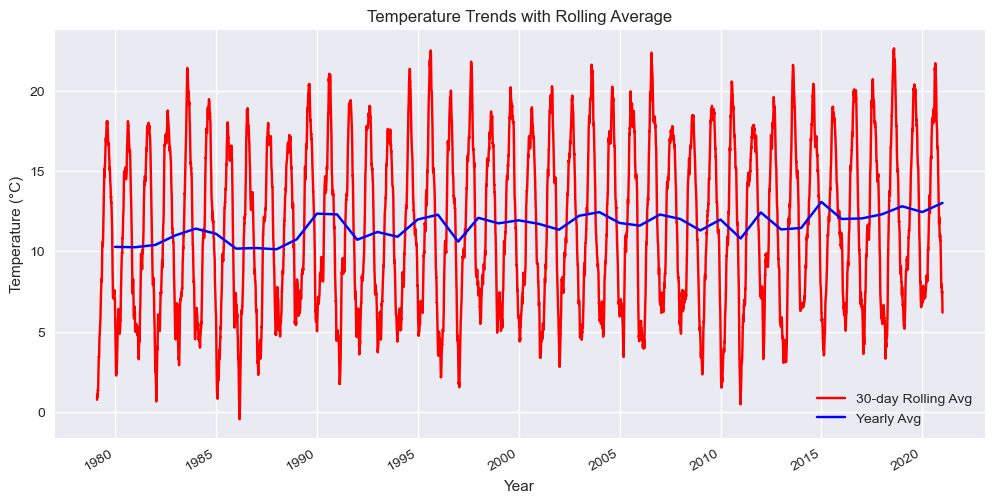

In [68]:
# 30-day rolling average vs yearly average
plt.figure(figsize=(12,6))
df['mean_temp'].rolling(30).mean().plot(label='30-day Rolling Avg', color='red')
df['mean_temp'].resample('Y').mean().plot(label='Yearly Avg', color='blue')
plt.title("Temperature Trends with Rolling Average")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()

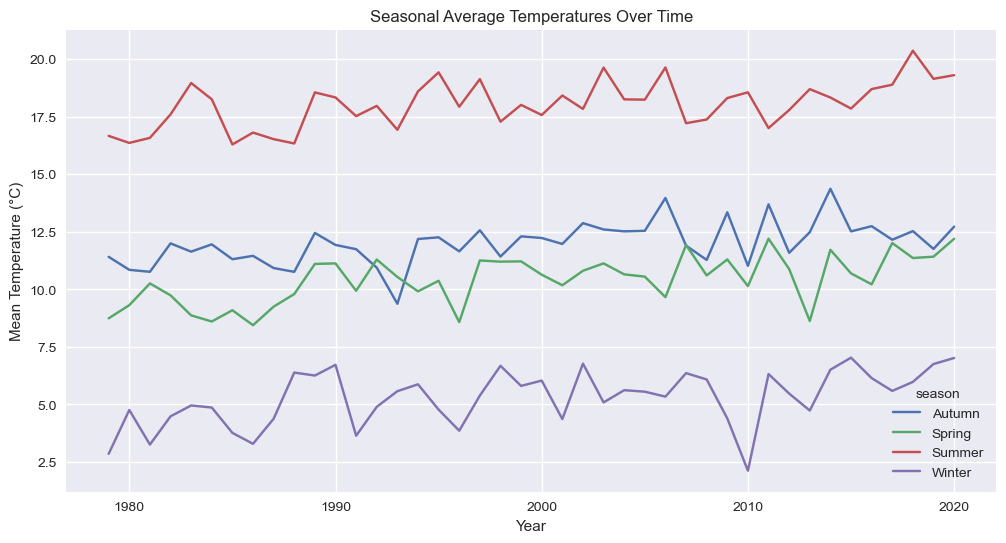

In [69]:
# Group by year and season
seasonal = df.groupby(['year','season'])['mean_temp'].mean().unstack()
seasonal.plot(figsize=(12,6))
plt.title("Seasonal Average Temperatures Over Time")
plt.xlabel("Year")
plt.ylabel("Mean Temperature (°C)")
plt.show()


#### Seasonal Average Temperatures Over Time

This seasonal breakdown highlights how warming is not evenly distributed across the year.  
Summers in London have become consistently warmer since the late 20th century, with recent years exceeding 20&deg;C on average.  
Winters also show a warming trend but with greater variability, reflecting occasional extreme cold spells.  
Meanwhile, spring and autumn have gradually warmed but remain more stable. This suggests that climate change is amplifying summer heat in particular, which has implications for urban planning, health risks during heatwaves, and energy usage for cooling.


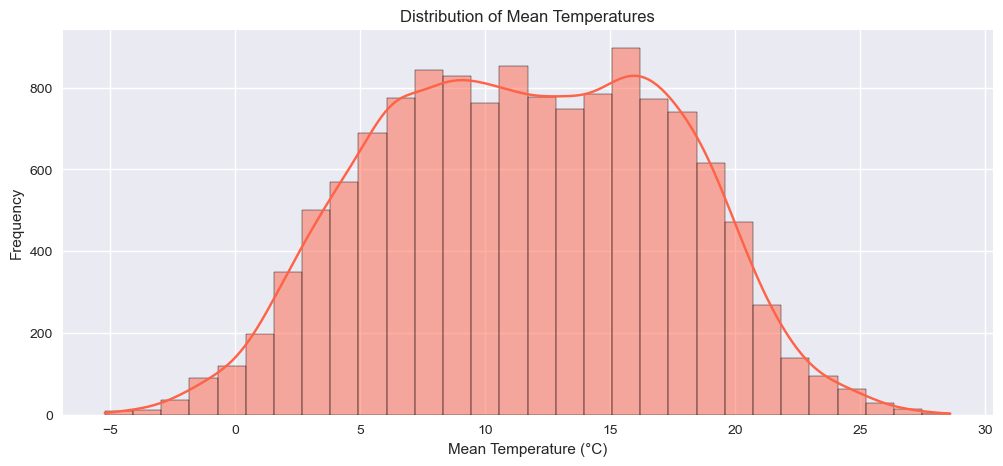

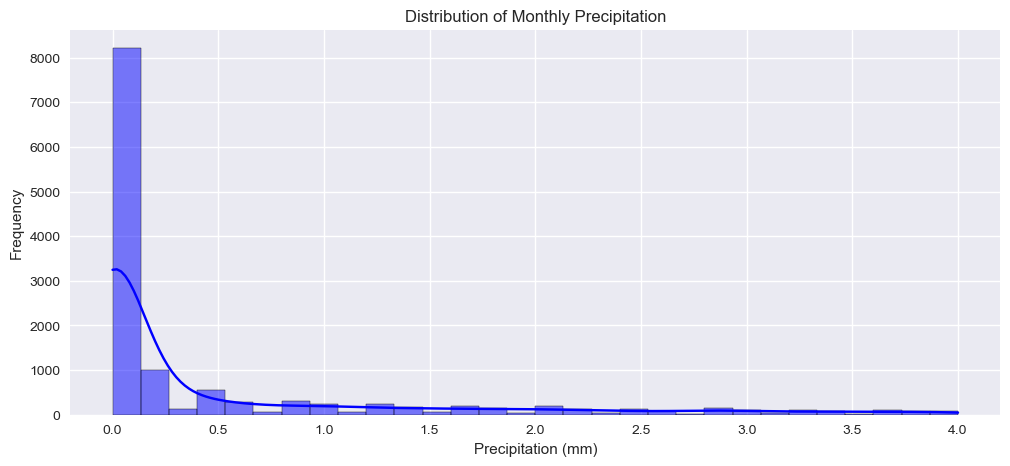

In [70]:
# Histograms + KDE plots
plt.figure(figsize=(12,5))
sns.histplot(df['mean_temp'], bins=30, kde=True, color="tomato")
plt.title("Distribution of Mean Temperatures")
plt.xlabel("Mean Temperature (°C)")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(12,5))
sns.histplot(df['precipitation'], bins=30, kde=True, color="blue")
plt.title("Distribution of Monthly Precipitation")
plt.xlabel("Precipitation (mm)")
plt.ylabel("Frequency")
plt.show()


### Distribution of Temperatures and Rainfall
The histogram of mean temperatures shows how most daily/monthly values cluster around a central range.  
- A **bell-like distribution** suggests stability, while multiple peaks may indicate strong seasonality.  
- The precipitation histogram is typically **right-skewed** (many dry days/months, fewer very wet ones).  
Together, these plots help us understand the **variability** in weather rather than just the averages.


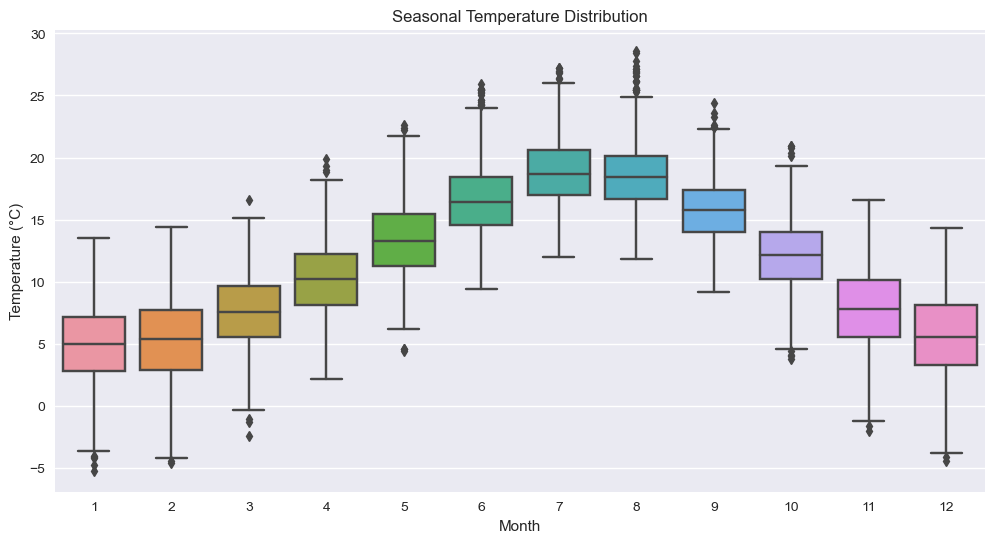

In [ ]:
### Seasonal Temperature Distribution

plt.figure(figsize=(12,6))
sns.boxplot(x='month', y='mean_temp', data=df.reset_index())
plt.title("Seasonal Temperature Distribution")
plt.xlabel("Month")
plt.ylabel("Temperature (°C)")
plt.show()


#### Seasonal Temperature Distribution

This boxplot highlights how temperatures vary across the months.  
Winter months (Dec–Feb) cluster at lower values, while July and August show the highest medians.  
The spread also shows variability, with more stable temperatures in summer than in transitional months like spring and autumn.  


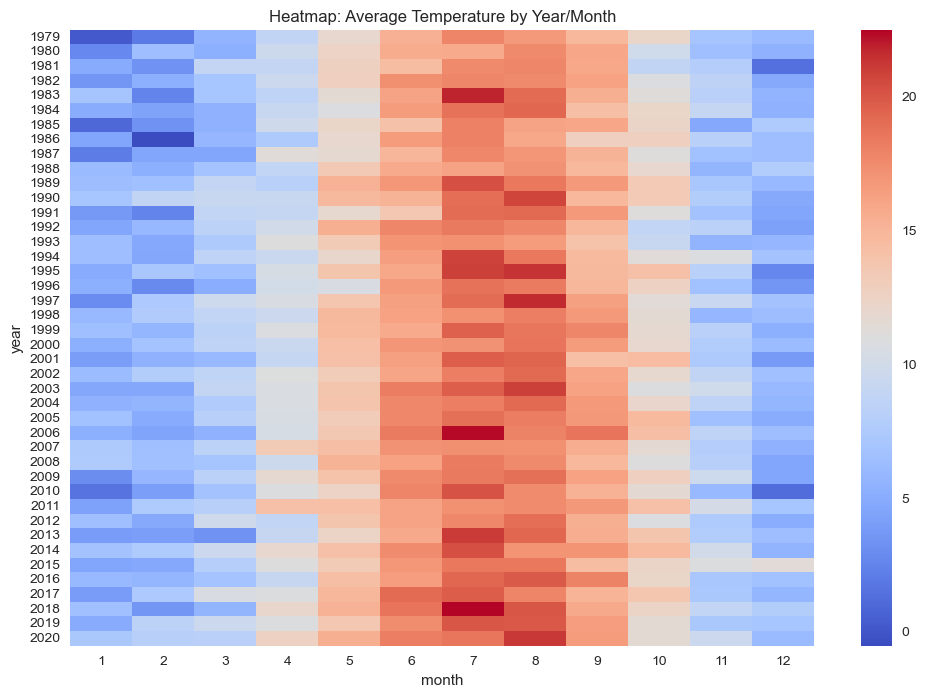

In [ ]:
### Heatmap of Temperatures by Year/Month

pivot = df.pivot_table(values="mean_temp", index="year", columns="month", aggfunc="mean")
plt.figure(figsize=(12,8))
sns.heatmap(pivot, cmap="coolwarm", annot=False)
plt.title("Heatmap: Average Temperature by Year/Month")
plt.show()


#### Heatmap of Temperatures by Year/Month

The heatmap provides a compact view of average monthly temperatures over time.  
Warmer months consistently appear in mid-year, with cooler months at the start and end.  
The visual grid helps spot unusual years, though overall the seasonal rhythm remains steady.  


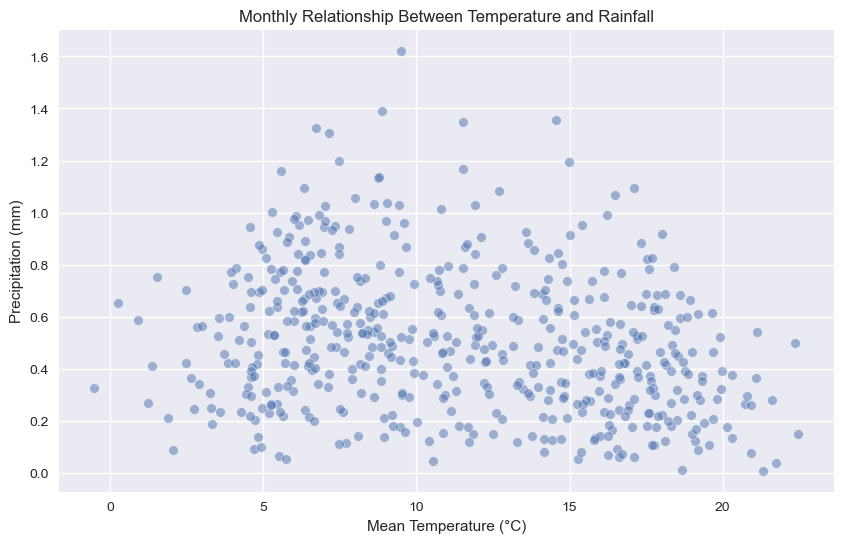

In [ ]:
### Temperature vs Rainfall Relationship

plt.figure(figsize=(10,6))
sns.scatterplot(x="mean_temp", y="precipitation", data=df.resample('M').mean(numeric_only=True), alpha=0.5)
plt.title("Monthly Relationship Between Temperature and Rainfall")
plt.xlabel("Mean Temperature (°C)")
plt.ylabel("Precipitation (mm)")
plt.show()


#### Temperature vs Rainfall Relationship

This scatterplot explores the relationship between monthly average temperature and rainfall.  
The points are widely spread, showing little to no direct correlation.  
This suggests that London’s rainfall is not strongly tied to temperature patterns.  


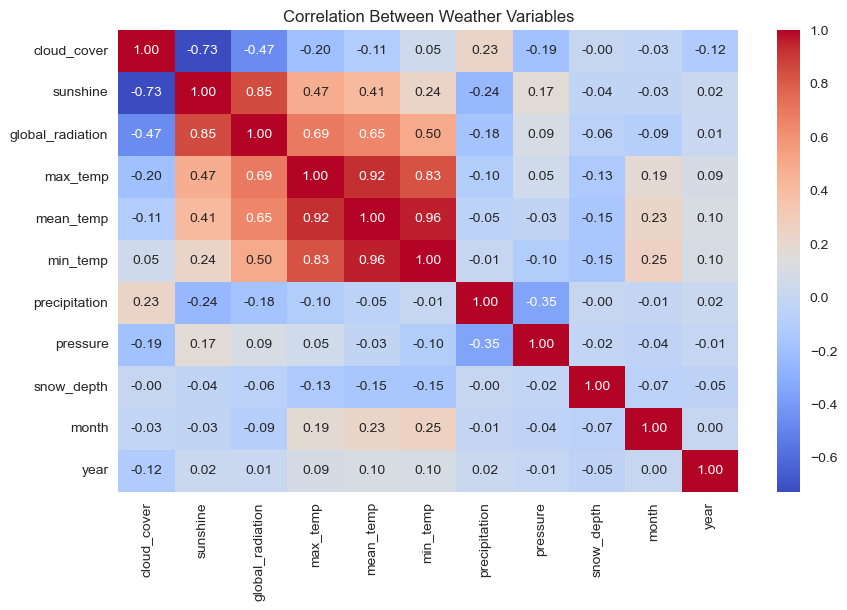

In [74]:
# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Weather Variables")
plt.show()


### Relationships Between Weather Variables
The correlation heatmap quantifies how different variables move together:  
- A **positive correlation** means two metrics increase together (e.g., sunshine and temperature).  
- A **negative correlation** means one rises as the other falls (e.g., temperature vs. snowfall, if available).  
- Near-zero correlation suggests independence.  
This matrix provides quick insight into which variables may be **predictive of each other**, guiding later modeling.


In [75]:
# Hottest months
print("Top 5 Hottest Months:")
display(df.resample("M").mean(numeric_only=True).sort_values("mean_temp", ascending=False).head(5))

# Coldest months
print("Top 5 Coldest Months:")
display(df.resample("M").mean(numeric_only=True).sort_values("mean_temp", ascending=True).head(5))

# Wettest months
print("Top 5 Wettest Months:")
display(df.resample("M").sum(numeric_only=True).sort_values("precipitation", ascending=False).head(5))


Top 5 Hottest Months:


,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth,month,year
date,,,,,,,,,,,
2018-07-31,3.344828,9.003448,194.379310,28.444828,22.479310,16.372414,0.151724,101706.896552,0.0,7.0,2018.0
2006-07-31,2.866667,8.680000,247.200000,28.170000,22.360000,16.573333,0.500000,101869.333333,0.0,7.0,2006.0
1983-07-31,3.428571,8.550000,247.107143,27.964286,21.760714,15.917857,0.039286,101903.571429,0.0,7.0,1983.0
1997-08-31,5.192308,6.726923,193.192308,26.296154,21.623077,16.807692,0.280769,101633.846154,0.0,8.0,1997.0
1995-08-31,3.709677,9.525806,229.645161,26.538710,21.322581,15.619355,0.009677,101996.129032,0.0,8.0,1995.0


Top 5 Coldest Months:


,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth,month,year
date,,,,,,,,,,,
1986-02-28,5.703704,2.103704,47.666667,1.659259,-0.540741,-2.740741,0.325926,101775.925926,1.185185,2.0,1986.0
1979-01-31,5.478261,2.113043,30.217391,4.008696,0.252174,-2.886957,0.652174,101314.347826,1.782609,1.0,1979.0
1985-01-31,5.518519,1.637037,27.851852,4.381481,0.900000,-2.000000,0.588889,101517.777778,0.370370,1.0,1985.0
2010-12-31,6.423077,0.542308,16.730769,4.561538,1.234615,-1.365385,0.269231,101595.769231,0.923077,12.0,2010.0
1981-12-31,5.391304,1.913043,25.217391,4.400000,1.352174,-1.517391,0.413043,100504.347826,1.608696,12.0,1981.0


Top 5 Wettest Months:


,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth,month,year
date,,,,,,,,,,,
1998-04-30,147.0,89.3,3223.0,294.40,218.2,138.4,37.3,2307780.0,0.0,92,45954
2020-10-31,127.0,50.5,1814.0,358.15,276.5,200.8,32.4,2427790.0,0.0,240,48480
2012-04-30,104.0,117.6,3578.0,301.60,204.4,100.9,32.0,2314210.0,0.0,92,46276
2001-10-31,125.0,97.7,1873.0,411.70,334.7,254.5,31.2,2333810.0,0.0,230,46023
1983-03-31,168.0,87.8,2721.0,325.80,210.2,92.5,29.1,3050970.0,0.0,90,59490


### Highlighting Extreme Events
Beyond averages, extremes often have the greatest impact on society and ecosystems.  
- The **hottest months** may align with heatwaves.  
- The **coldest months** highlight severe winters.  
- The **wettest months** may indicate flooding risks.  
Listing these extremes provides concrete examples of **climate variability** that averages alone can miss.


In [ ]:
### Interactive Temperature Trends (Plotly)

fig = px.line(
    df.resample("M").mean(numeric_only=True).reset_index(),
    x="date", y="mean_temp",
    title="Monthly Avg Temperature (Interactive with Plotly)",
    labels={"mean_temp": "Mean Temperature (°C)"}
)
fig.show()


### Conclusion  

The analysis reveals London’s weather follows consistent seasonal cycles, with warm summers and cool winters repeating every year.  
Rainfall is more irregular, showing variability without a strong seasonal link.  
While no dramatic warming trend is visible in this dataset period, the visualizations provide a clear overview of London’s climate patterns.  
